In [66]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal

In [50]:
%config InlineBackend.figure_format='retina'

# Dummy data

In [51]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * np.sqrt(0.04)
test_x = torch.linspace(0, 1, 51)

# Text book GP

In [52]:
def plot(observed_pred, test_x, train_x=None, train_y=None):
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    with torch.no_grad():

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        if train_x is not None and train_y is not None:
            # Plot training data as black stars
            ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        #ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    return ax

Before training:
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


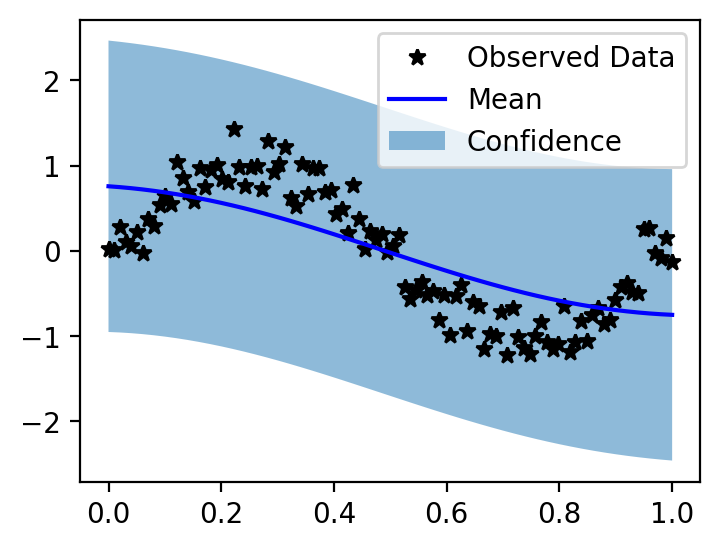

After training:
Parameter name: likelihood.noise_covar.raw_noise           value = -3.1852986812591553
Parameter name: mean_module.raw_constant                   value = 0.09548411518335342
Parameter name: covar_module.raw_outputscale               value = 0.5294453501701355
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.1902621984481812


<Axes: >

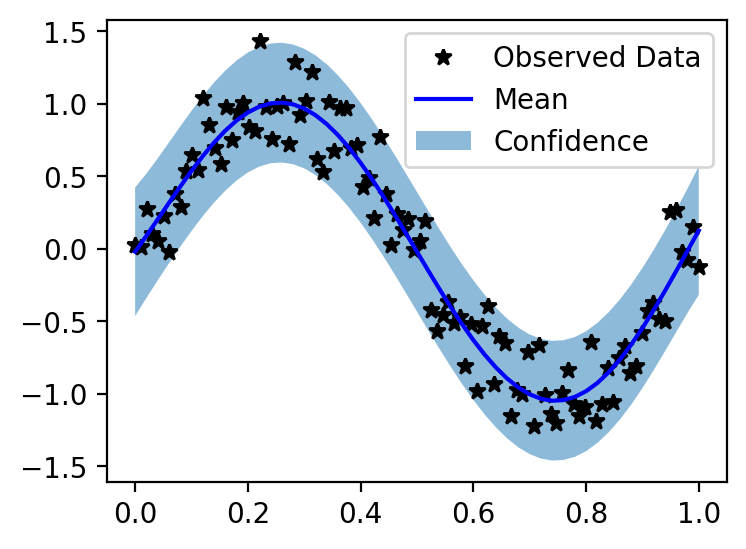

In [53]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

print("Before training:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    observed_pred = likelihood(output)

plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x)
plt.show()

# -------------------- Train --------------------------------

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

print("After training:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    observed_pred = likelihood(output)

plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x)

# Bayes Opt

In [54]:
# We will use the simplest form of GP model, exact inference
class GP(gpytorch.models.ExactGP):
    def __init__(self):
        super(GP, self).__init__(
            torch.empty(0), 
            torch.empty(0), 
            gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
            
    def predict(self, test_x):
        
        # Get into evaluation (predictive posterior) mode
        self.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = self(test_x)
            observed_pred = self.likelihood(output)
        return observed_pred
    
    @property
    def gp_param(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
        
    def fit(self, train_x, train_y, learning_rate=0.1, n_epochs=25):
    
        self.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # Find optimal model hyperparameters
        self.train()

        # Use the adam optimizer
        # Includes GaussianLikelihood parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        
        previous_gp_param = self.gp_param.clone()

        for i in range(n_epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()
            
            if torch.allclose(self.gp_param, previous_gp_param, rtol=1e-05, atol=1e-04):
                print(f"Early stop at iter {i}")
                break
            previous_gp_param = self.gp_param.clone()

Early stop at iter 176


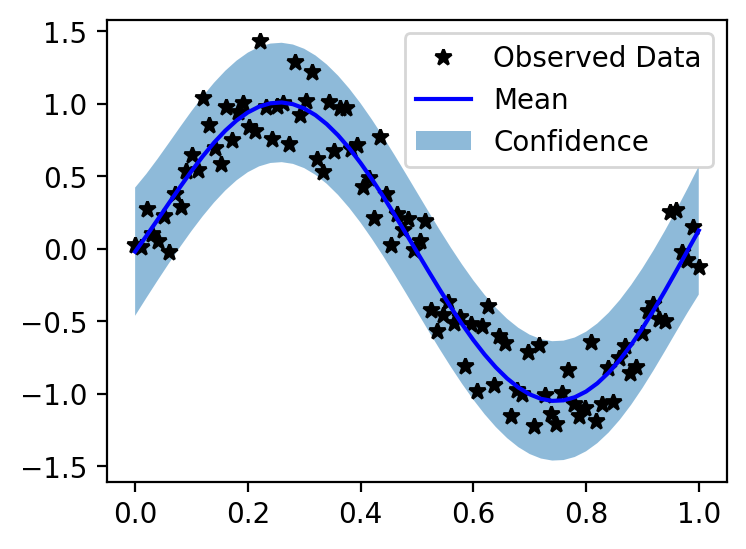

In [55]:
gp = GP()
gp.fit(train_x, train_y, n_epochs=1000)
pred = gp.predict(test_x)
plot(pred, train_x=train_x, train_y=train_y, test_x=test_x);

In [56]:
def f(x, add_noise=True):
    
    y = torch.sin(x * (2 * np.pi))
    if add_noise:
        y += torch.randn(x.size()) * np.sqrt(0.04)
        
    return y

In [57]:
class BayesOpt:
    
    def __init__(self):
        self.gp = GP()

    def x_new(self, n_warmup=1000):
        
        def objective(x):
            pred = self.gp.predict(torch.from_numpy(x).float())
            ucb = self.ucb(pred)
            return - ucb.numpy()
        
        x_warmup = np.random.random(n_warmup)
        y_warmup = - objective(x_warmup)
        bounds = [[0., 1.]]
        best_x = x_warmup[np.argmax(y_warmup)]
        res = minimize(objective,
               x0=best_x,
               bounds=bounds,
               method="L-BFGS-B")
        x_max = torch.from_numpy(res.x).float()
        return x_max
    
    def argmax_m(self, n_warmup=1000):
        
        def objective(x):
            pred = self.gp.predict(torch.from_numpy(x).float())
            return - pred.mean
        
        x_warmup = np.random.random(n_warmup)
        y_warmup = - objective(x_warmup)
        bounds = [[0., 1.]]
        best_x = x_warmup[np.argmax(y_warmup)]
        res = minimize(objective,
               x0=best_x,
               bounds=bounds,
               method="L-BFGS-B")
        x_max = torch.from_numpy(res.x).float()
        return x_max
        
    def ucb(self, pred, gamma=2.576):
        # gamma param value from https://github.com/fmfn/BayesianOptimization
        # a(x;λ)=μ(x)+λσ(x)
        return pred.mean + gamma*pred.stddev
    
    def run(self, f, n_warm_up=5, n_epochs=25):
        warmup_x = torch.rand(n_warm_up)
        warmup_y = f(warmup_x)
        train_x = warmup_x.clone()
        train_y = warmup_y.clone()
        for _ in range(n_epochs):
            self.gp.fit(train_x, train_y)
            x_new = self.x_new()
            y_new = f(x_new)
            train_x = torch.cat((train_x, x_new), 0)
            train_y = torch.cat((train_y, y_new), 0)
            
            if torch.allclose(train_x[-1], train_x[-2]):
                print(f"Converged at iter {_}")
                break
                        
        x_max = self.argmax_m()
        train_x, train_y = train_x[n_warm_up:], train_y[n_warm_up:]
        return Namespace(
            train_x=train_x, train_y=train_y, 
            warmup_x=warmup_x, warmup_y=warmup_y,
            x_max=x_max)
        
bo = BayesOpt()
bo_res = bo.run(f)

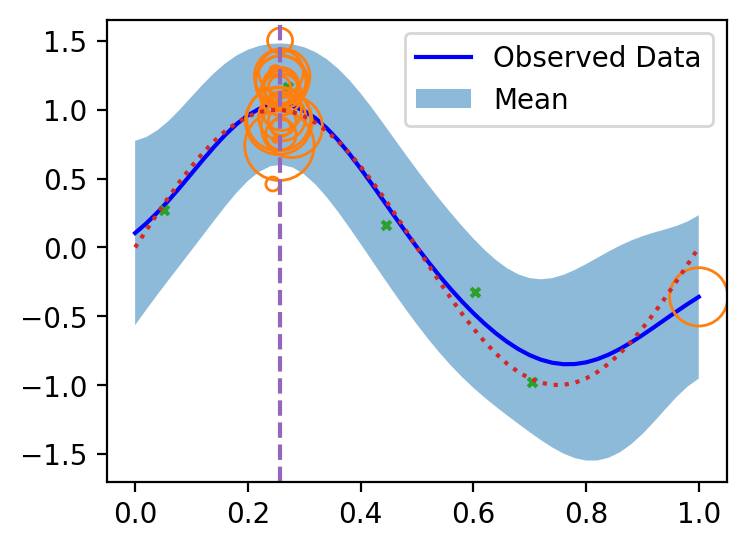

In [58]:
pred = bo.gp.predict(test_x)
ax = plot(pred, train_x=None, train_y=None, test_x=test_x)
# Plot warming up as crosses
ax.scatter(bo_res.warmup_x.numpy(), 
           bo_res.warmup_y.numpy(), 
           marker="x", 
           c='C2', 
           zorder=2, 
           s=10)
# Plot training data as dots
ax.scatter(bo_res.train_x.numpy(), 
           bo_res.train_y.numpy(), 
           facecolors='none', 
           color='C1', 
           zorder=2, 
           s=(1+ np.arange(len(bo_res.train_x)))**2)

ax.plot(test_x, f(test_x, add_noise=False), color='C3', linestyle=":")
ax.axvline(x=bo_res.x_max.item(), color='C4', linestyle="--");

# Model activity

In [59]:
def f(a=-0.1):
    x = np.linspace(0, 24, 100)
    y= a*x**4 + 0.3*x**3 + 3*x**2 - 4*x +10
    plt.plot(x, y)

In [60]:
interact(f, a=widgets.FloatSlider(min=-1, max=1, step=0.000, value=1));

interactive(children=(FloatSlider(value=1.0, description='a', max=1.0, min=-1.0, step=0.0), Output()), _dom_cl…

# Active inference walking objective

We model the number of step for each interval $\Delta t$ (e.g. 5 min) with a Gaussian process that takes as input the context $c$. We then can compute estimate the number of total time step in the day, mean + SD. We can express the preference as a Gaussian distribution centered around the goal. 

Problem: it would be penalized if we expect more.